#  IN3050/IN4050 Mandatory Assignment 1: Traveling Salesman Problem


## Rules
Before you begin the exercise, review the rules at this website:
https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html
(This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers
with others.)

Especially, notice that you are **not allowed to use code or parts of code written by others** in your submission. We do check your code against online repositories, so please be sure to **write all the code yourself**. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": https://www.uio.no/english/studies/examinations/cheating/index.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, February 25 2022, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs.

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

## Introduction
In this exercise, you will attempt to solve an instance of the traveling salesman problem (TSP) using different
methods. The goal is to become familiar with evolutionary algorithms and to appreciate their effectiveness on a
difficult search problem. You may use whichever programming language you like, but we strongly suggest that
you try to use Python, since you will be required to write the second assignment in Python. You must write
your program from scratch (but you may use non-EA-related libraries).


|  &nbsp;   | Barcelona | Belgrade |  Berlin | Brussels | Bucharest | Budapest |
|:---------:|:---------:|:--------:|:-------:|:--------:|:---------:|:--------:|
| Barcelona |     0     |  1528.13 | 1497.61 |  1062.89 |  1968.42  |  1498.79 |
|  Belgrade |  1528.13  |     0    |  999.25 |  1372.59 |   447.34  |  316.41  |
|   Berlin  |  1497.61  |  999.25  |    0    |  651.62  |  1293.40  |  1293.40 |
|  Brussels |  1062.89  |  1372.59 |  651.62 |     0    |  1769.69  |  1131.52 |
| Bucharest |  1968.42  |  447.34  | 1293.40 |  1769.69 |     0     |  639.77  |
|  Budapest |  1498.79  |  316.41  | 1293.40 |  1131.52 |   639.77  |     0    |


<center>Figure 1: First 6 cities from csv file.</center>


## Problem
The traveling salesman, wishing to disturb the residents of the major cities in some region of the world in
the shortest time possible, is faced with the problem of finding the shortest tour among the cities. A tour
is a path that starts in one city, visits all of the other cities, and then returns to the starting point. The
relevant pieces of information, then, are the cities and the distances between them. In this instance of the
TSP, a number of European cities are to be visited. Their relative distances are given in the data file, *european_cities.csv*, found in the zip file with the mandatory assignment.

(You will use permutations to represent tours in your programs. If you use Python, the **itertools** module provides
a permutations function that returns successive permutations, this is useful for exhaustive search)

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [2]:
#Installing a python library for displaying your plans on a map
!pip install basemap

In [3]:
#IMPORTANT: If you are unable to import Basemap below, try to restart your
#kernel (under "Kernel" in the menu above).
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import itertools as iter
import time
import random
import sys
#Lists of city coordinates
city_coords={"Barcelona":[2.154007, 41.390205], "Belgrade": [20.46,44.79], "Berlin": [13.40,52.52], "Brussels":[4.35,50.85],"Bucharest":[26.10,44.44], "Budapest": [19.04,47.50], "Copenhagen":[12.57,55.68], "Dublin":[-6.27,53.35], "Hamburg": [9.99, 53.55], "Istanbul": [28.98, 41.02], "Kiev": [30.52,50.45], "London": [-0.12,51.51], "Madrid": [-3.70,40.42], "Milan":[9.19,45.46], "Moscow": [37.62,55.75], "Munich": [11.58,48.14], "Paris":[2.35,48.86], "Prague":[14.42,50.07], "Rome": [12.50,41.90], "Saint Petersburg": [30.31,59.94], "Sofia":[23.32,42.70], "Stockholm": [18.06,59.33],"Vienna":[16.36,48.21],"Warsaw":[21.02,52.24]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


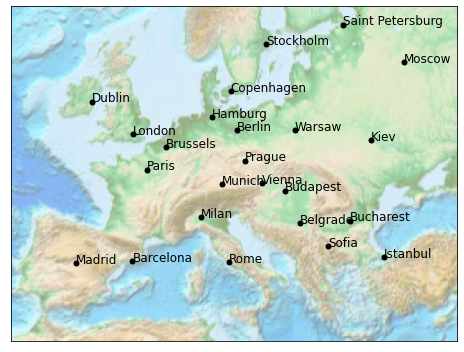

In [4]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]
    
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=4E6, height=3E6, 
            lat_0=49, lon_0=13,)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
for city,location in city_coords.items():
    x, y = m(location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12);

In [5]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution=None,
                width=4E6, height=3E6, 
                lat_0=49, lon_0=13,)
    m.etopo(scale=0.5, alpha=0.5)

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) -1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = m(current_city_coords[0], current_city_coords[1])
        #Plotting a line to the next city
        next_x, next_y = m(next_city_coords[0], next_city_coords[1])
        plt.plot([x,next_x], [y,next_y])
        
        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12);
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = m(first_city_coords[0], first_city_coords[1])
    plt.plot([next_x,first_x],[next_y,first_y])

['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul', 'Kiev', 'London', 'Madrid', 'Milan', 'Moscow', 'Munich', 'Paris', 'Prague', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm', 'Vienna', 'Warsaw']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


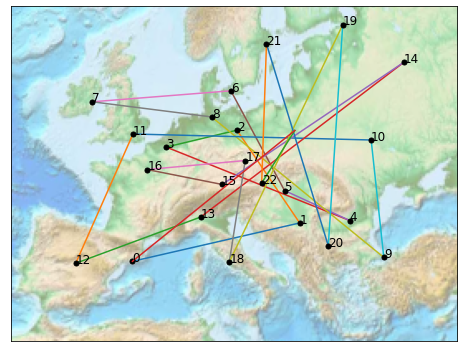

In [4]:
#Example usage of the plotting-method.
plan = list(city_coords.keys()) # Gives us the cities in alphabetic order
print(plan)
plot_plan(plan)

## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.


6 cities:  ['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest']
Solution:  ('Barcelona', 'Belgrade', 'Bucharest', 'Budapest', 'Berlin', 'Brussels')
The shortest distance of 6 cities:  5018.8099999999995
Exhaustive search of 6 cities took (secounds):  0.003988981246948242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



10 cities:  ['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul']
Solution:  ('Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Belgrade', 'Istanbul', 'Bucharest', 'Budapest', 'Berlin')
The shortest distance of 10 cities:  7486.309999999999
Exhaustive search of 10 cities took (secounds):  37.757163286209106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


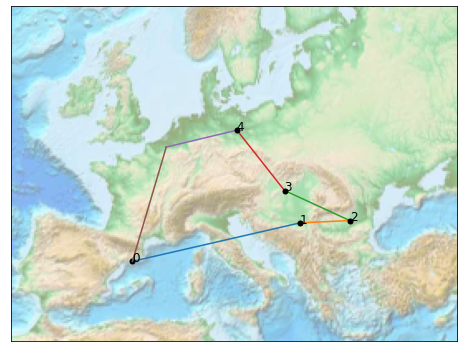

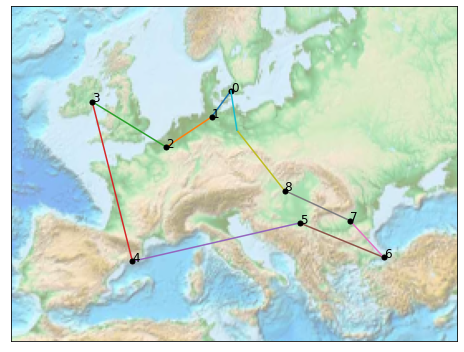

In [39]:
# Implement the algorithm here
def exhaustive_search(cities_name, dis_matrix):
    """
    Args: 
    cities_name (numpy array, symbol)
    dis_matrix (numpy array, float)
    
    Create per_cities that contains all permutation combination of 
    cities_name. Then loop through every permutation and get the 
    distance each permutation represents.
    
    To decode the permutation from ['city1', 'city2' ...] to distance,
    use partial mapping, find city index by looking at cities_name.
    1. Find index to current city, and index to next city.
    2. Get distance between tow cities by using dis_matrix[i_current,i_next]
    3. Sum the distance, and compare with shortest
    
    """
    per_cities = list(iter.permutations(cities))
    solution = None
    shortest = None
    
    #Search all permutations
    for s in per_cities:
        #Initialize a start city, get index to start city
        start_city = s[0]
        i_current = cities_name.index(s[0])
        i_next = None
        dis = 0
        #Loop through alle cities in a permutation 
        for i in range(len(s)):
            #For all cities that is not the last in permutation, find next
            if i < len(s)-1:
                i_next = cities_name.index(s[i+1])
                dis += float(dis_matrix[i_current][i_next])
                
                #Update current city to next city
                i_current = i_next
            #For the last city set next city to visit to start city
            else:
                i_next = cities_name.index(s[0])
                dis += float(dis_matrix[i_current][i_next])
        
        #Compare with shortest
        if shortest == None:
            shortest = dis
            solution = s
        elif dis < shortest:
            shortest = dis
            solution = s
            
    return solution,shortest

cities = data[0][0:6]
dis_matrix = data[1:7]

start_time = time.time()
solution, shortest = exhaustive_search(cities,dis_matrix)
end_time = time.time()
print()
print("6 cities: ", cities)
print("Solution: ", solution)
print("The shortest distance of 6 cities: ", shortest)
print("Exhaustive search of 6 cities took (secounds): ", end_time-start_time)
plot_plan(solution)



cities = data[0][0:10]
dis_matrix = data[1:11]

start_time = time.time()
solution, shortest = exhaustive_search(cities,dis_matrix)
end_time = time.time()
print()
print("10 cities: ", cities)
print("Solution: ", solution)
print("The shortest distance of 10 cities: ", shortest)
print("Exhaustive search of 10 cities took (secounds): ", end_time-start_time)
plot_plan(solution)







What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

In [6]:
# Answer
"""
The shortest tour of 10 first cities is 
('Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Belgrade', 
'Istanbul', 'Bucharest', 'Budapest', 'Berlin', 'Copenhagen').

The program took about 37.5596s to find the solution (This time may change because I run the search after I wrote this.).
Number of iteration of 10! is 3628800 iterations. 
37,5596s/3628800 itrations = 1.035*10^-5s/itrations
24! iterations * 1,035*10^-5s/iterations = 6.417*10^18s.
Approximation of 24 cities is 6.417*10^18s.

"""

"\nThe shortest tour of 10 first cities is \n('Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Belgrade', \n'Istanbul', 'Bucharest', 'Budapest', 'Berlin', 'Copenhagen').\n\nThe program took about 45,131s to find the solution.\n\nSearch time of:\n6 cities : 0,0049s\n7 cities : 0,0493s\n8 cities: 0,5111s\n9 cities : 4,5837s\n10 cities : 45,131s\n\nBy observing, the time constant is multipled by a factor around 10,\nwhen the numbers of search city increase by 1.\nWhen 10 cities takes 45,13s, then 24 cities should take a time by multiple\nof 10^14 of the time by searching througth 10 cities. That is 45*10^14s.\n"

## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 


Numbers of search cities:  10
The best solution after 20 runs:  ['Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Belgrade', 'Istanbul', 'Bucharest', 'Budapest', 'Berlin']
Best distance:  7486.309999999999
Time performance:  0.0019931793212890625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The worst solution after 20 runs:  ['Berlin', 'Budapest', 'Belgrade', 'Istanbul', 'Bucharest', 'Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Barcelona']
Worst distance:  8349.94
Time performance:  0.0019948482513427734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Numbers of search cities:  24
The best solution after 20 runs:  ['Stockholm', 'Copenhagen', 'Hamburg', 'Brussels', 'London', 'Dublin', 'Paris', 'Madrid', 'Barcelona', 'Rome', 'Milan', 'Munich', 'Berlin', 'Prague', 'Vienna', 'Budapest', 'Belgrade', 'Sofia', 'Istanbul', 'Bucharest', 'Warsaw', 'Kiev', 'Moscow', 'Saint Petersburg']
Best distance:  12655.050000000005
Time performance:  0.06376123428344727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The worst solution after 20 runs:  ['Madrid', 'Barcelona', 'Vienna', 'Moscow', 'Saint Petersburg', 'Stockholm', 'Copenhagen', 'Budapest', 'Belgrade', 'Sofia', 'Istanbul', 'Bucharest', 'Kiev', 'Warsaw', 'Berlin', 'Hamburg', 'Prague', 'Munich', 'Rome', 'Milan', 'Paris', 'Brussels', 'London', 'Dublin']
Worst distance:  15274.760000000002
Time performance:  0.05285930633544922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


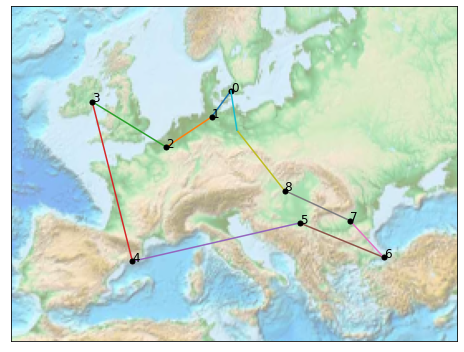

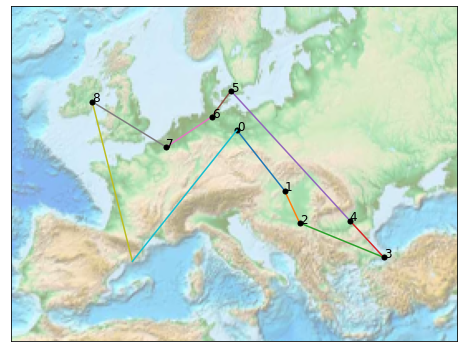

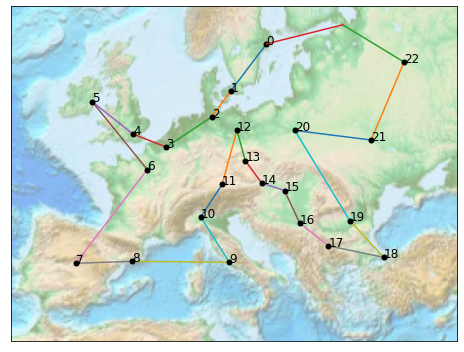

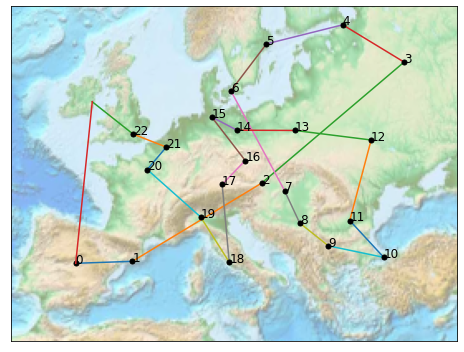

In [6]:
# Implement the algorithm here
def find_dist(cities_name, dis_matrix, cities):
    """
    This is just part from exhaustive_search, to find the total distance of a given set of cities.
    """
    start_city = cities[0]
    i_current = cities_name.index(cities[0])
    dis = 0
    
    for i in range(len(cities)):
            #For all cities that is not the last in permutation, find next
            if i < len(cities)-1:
                i_next = cities_name.index(cities[i+1])
                dis += float(dis_matrix[i_current][i_next])
                
                
                #Update current city to next city
                i_current = i_next
            #For the last city set next city to visit to start city
            else:
                i_next = cities_name.index(cities[0])
                dis += float(dis_matrix[i_current][i_next])
    return dis

def swap(a,b,lst):
    liste = lst.copy()
    i_a = liste.index(a)
    i_b = liste.index(b)
    liste[i_a] = b
    liste[i_b] = a
    return liste
        

def hill_climbing(cities_name, dis_matrix, solution):
    """
    Args: 
    cities_name (list with symbol)
    dis_matrix (2d list with symbol that can convert to float)
    solution (list with symbol)
    
    Hill_climbing search, change solution by swaping 2 cities. 
    If the result is better then update the result.
    Each change between to solution is small.
    
    1. Take a random solution
    2. For every node, swap it with every possible neighbors
    3. If swaping gives a better result, then keep it and use it in next iteration
    4. Check every time after swaped every node with every neighbors, if we found a better result
       then do it again.
    5. Else return solution we found.
    
    The hill_climbing will not guarantee to find the best solution, but is much faster than Exhaustive.
    """
    shortest = find_dist(cities_name,dis_matrix,solution)
    found_better = True
    orgin_list = solution.copy()
    
    while(found_better):
        #initial value to be the previous iteration 
        this_iter_shortest = shortest
        this_iter_solution = solution
        
        #going through every node
        for city in orgin_list:
            #Start value
            tmp_dis = this_iter_shortest
            tmp = this_iter_solution.copy()
            
            #going through every possible neighbor
            for neighbor in orgin_list:
                new_tmp = swap(city,neighbor,tmp)
                new_dis = find_dist(cities_name, dis_matrix,new_tmp)
                
                #Keep the best solution
                if new_dis < tmp_dis:
                    tmp = new_tmp
                    tmp_dis = new_dis
            
            #Keep the best solution after swaping a city with every possible neighbor
            if tmp_dis < this_iter_shortest:
                this_iter_shortest = tmp_dis
                this_iter_solution = tmp
        
        #we finish to swap every cities, with every passible neighbor to each city
        #Update the best solution, if we have'nt found any better solution, then finish search
        if this_iter_shortest < shortest:
            shortest = this_iter_shortest
            solution = this_iter_solution
        else:
            found_better = False
    
    return solution, shortest
                    

def run_20(data,n):
    """
    This is for running hill climbing 20 times,
    and report and plot the best and worst result.
    """
    cities_name = data[0][0:n]
    dis_matrix = data[1:n+1]
    cities = data[0][0:n]
    
    best_solution = None
    best_dist = None
    best_time = None

    worst_solution = None
    worst_dist = None
    worst_time = None

    for i in range(0,20):
        random.shuffle(cities)

        start_time = time.time()
        solution,dist = hill_climbing(cities_name,dis_matrix,cities)
        end_time = time.time()
        
        if best_solution == None:
            best_solution = solution
            best_dist = dist
            worst_solution = solution
            worst_dist = dist
            best_time = end_time-start_time
            worst_time = end_time-start_time
        
        if dist < best_dist:
            best_solution = solution
            best_dist = dist
            best_time = end_time-start_time
        
        if dist > worst_dist:
            worst_solution = solution
            worst_dist = dist
            worst_time = end_time-start_time
    
    print()
    print("Numbers of search cities: ",n)
    print("The best solution after 20 runs: ", best_solution)
    print("Best distance: ", best_dist)
    print("Time performance: ", best_time)
    plot_plan(best_solution)
    
    print("The worst solution after 20 runs: ", worst_solution)
    print("Worst distance: ", worst_dist)
    print("Time performance: ", worst_time)
    plot_plan(worst_solution)

run_20(data,10)
run_20(data,24)


## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. Conclude which is best in terms of tour length and number of generations of evolution
time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.

Here is solution to population size 70: 

Numbers of search cities:  24
The best solution after 20 runs:  ['Copenhagen', 'Stockholm', 'Saint Petersburg', 'Moscow', 'Kiev', 'Warsaw', 'Bucharest', 'Istanbul', 'Sofia', 'Belgrade', 'Budapest', 'Vienna', 'Prague', 'Brussels', 'Paris', 'London', 'Dublin', 'Madrid', 'Barcelona', 'Rome', 'Milan', 'Munich', 'Berlin', 'Hamburg']
Best distance:  12763.389999999998
Time performance:  0.8587026596069336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The worst solution after 20 runs:  ['Dublin', 'Copenhagen', 'Stockholm', 'Saint Petersburg', 'Moscow', 'Paris', 'Madrid', 'Barcelona', 'Rome', 'Istanbul', 'Sofia', 'Belgrade', 'Milan', 'Munich', 'Warsaw', 'Kiev', 'Bucharest', 'Budapest', 'Vienna', 'Prague', 'Berlin', 'Hamburg', 'Brussels', 'London']
Worst distance:  16577.69
Time performance:  0.7261123657226562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Here is solution to population size 100: 

Numbers of search cities:  24
The best solution after 20 runs:  ['Hamburg', 'Brussels', 'Paris', 'London', 'Dublin', 'Madrid', 'Barcelona', 'Rome', 'Milan', 'Munich', 'Vienna', 'Budapest', 'Belgrade', 'Sofia', 'Istanbul', 'Bucharest', 'Kiev', 'Moscow', 'Saint Petersburg', 'Stockholm', 'Copenhagen', 'Warsaw', 'Prague', 'Berlin']
Best distance:  12416.87
Time performance:  1.0711743831634521


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The worst solution after 20 runs:  ['Paris', 'Barcelona', 'Madrid', 'Dublin', 'London', 'Berlin', 'Prague', 'Munich', 'Vienna', 'Budapest', 'Belgrade', 'Kiev', 'Moscow', 'Saint Petersburg', 'Stockholm', 'Copenhagen', 'Hamburg', 'Milan', 'Rome', 'Sofia', 'Istanbul', 'Bucharest', 'Warsaw', 'Brussels']
Worst distance:  15095.830000000004
Time performance:  1.3344733715057373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Here is solution to population size 150: 

Numbers of search cities:  24
The best solution after 20 runs:  ['Prague', 'Vienna', 'Budapest', 'Warsaw', 'Berlin', 'Hamburg', 'Copenhagen', 'Stockholm', 'Saint Petersburg', 'Moscow', 'Kiev', 'Bucharest', 'Istanbul', 'Sofia', 'Belgrade', 'Rome', 'Milan', 'Barcelona', 'Madrid', 'Dublin', 'London', 'Paris', 'Brussels', 'Munich']
Best distance:  12536.600000000002
Time performance:  1.429124116897583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The worst solution after 20 runs:  ['Hamburg', 'Copenhagen', 'Berlin', 'Prague', 'Budapest', 'Vienna', 'Munich', 'Barcelona', 'Madrid', 'Dublin', 'Stockholm', 'Saint Petersburg', 'Moscow', 'Kiev', 'Warsaw', 'Belgrade', 'Bucharest', 'Istanbul', 'Sofia', 'Rome', 'Milan', 'Paris', 'London', 'Brussels']
Worst distance:  14722.99
Time performance:  1.7213926315307617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


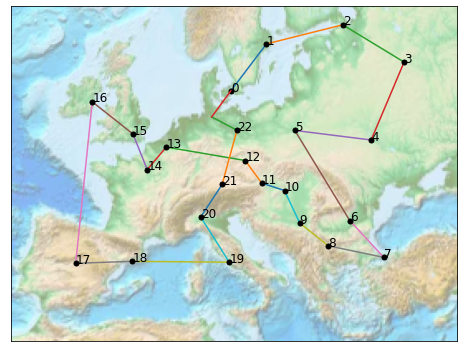

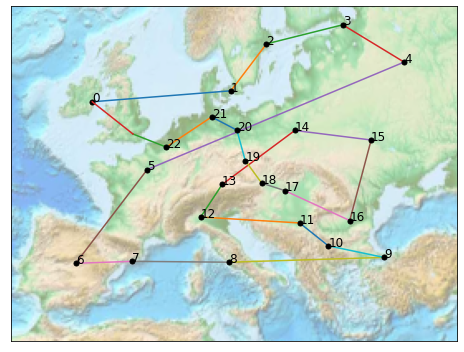

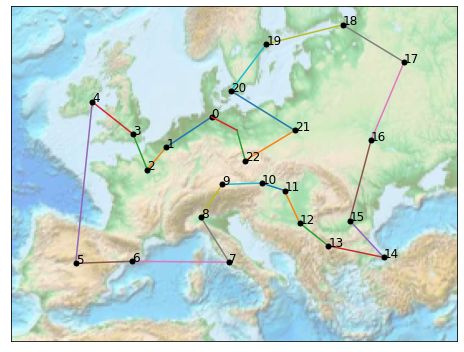

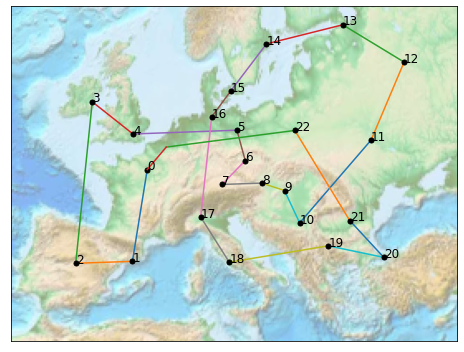

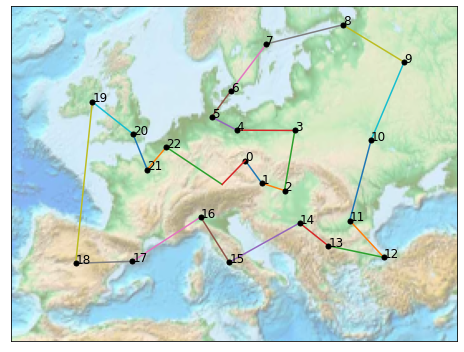

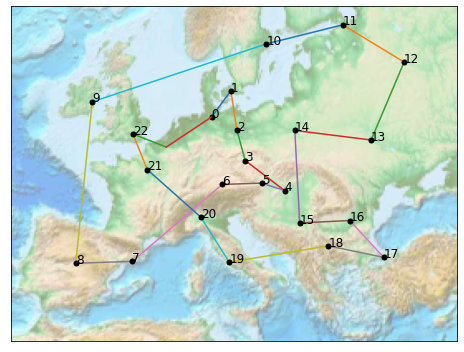

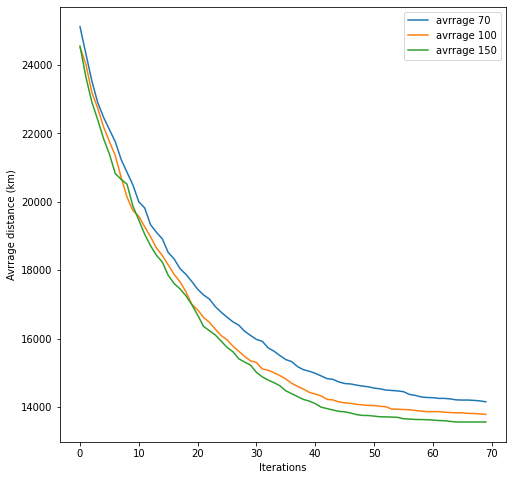

ALL DONE


In [36]:
#Reason to choose this crossover, because the adjacency is importent in this problem.
#The order of cities is not importent in this problem, but how cties are connected to each other are importent.
def pmx_pair(p1,p2):
    """
    Args:
    p1 (list of cities)
    p2 (list of cities)
    
    Partially mapped crossover, that take a subset and copy it in to the children.
    Partially map other element in p1 in to c1 by using p2 as lookup table.
    
    1. Pick up 2 random index that represent start and end of a subset.
    2. Then copy the subset into c1 and c2
    3. Place rest of allele in p1 into c1 by using p2 as a lookup table.
    
    """
    length = len(p1)
    start_i = random.randint(0,length)
    end_i = random.randint(0,length)

    #swap index
    if(end_i < start_i):
        tmp = start_i
        start_i = end_i
        end_i = tmp

    #Subset include start_i element and end_i element
    subset1 = p1[start_i: end_i+1].copy()
    subset2 = p2[start_i: end_i+1].copy()

    c1 = length*[None]
    c2 = length*[None]
    
    #Copy the subset into c1 and c2
    c1[start_i:end_i+1] = subset1
    c2[start_i:end_i+1] = subset2

     #Build c1
    for allele in p1:
        item = allele
        while allele not in c1:
            i = p2.index(item)
            if c1[i] == None:
                c1[i] = allele
            else:
                item = c1[i]

    #Build c2
    for allele in p2:
        item = allele
        while allele not in c2:
            i = p1.index(item)
            if c2[i] == None:
                c2[i] = allele
            else:
                item = c2[i]
    return c1,c2

def permutation_mutation_swap(genotype, p):
    """
    Args:
    genotype (list of cities)
    p (float)
    
    p is a float between 0 and 1, include 0 and 1.
    p represent the mutation rate of input genotype
    
    1. Choose 2 items from genotype and find the index of each.
    2. Swap them.
    """
    
    #Choose random float between 0 and 1, include 0 and 1
    #If mutation rate is bigger, then mutate genotype
    ran_float = random.uniform(0,1)
    if(ran_float < p):
        first = random.choice(genotype)
        secound = random.choice(genotype)
        
        first_i = genotype.index(first)
        secound_i = genotype.index(secound)
        
        #Swap
        genotype[first_i] = secound
        genotype[secound_i] = first
    
    return genotype

def init_population(size, orgin_lst):
    lst = orgin_lst.copy()
    population = size*[None]
    i = 0
    
    while(i < size):
        random.shuffle(lst)
        liste = lst.copy()
        population[i] = liste
        i += 1
    
    return population


def choose_subset(lst,subset_size):
    """
    Choose a subset, that include subset_size permutations.
    Say that same permutation can be choose multiple times.
    """
    subset = []
    while(len(subset) < subset_size):
        index = random.randint(0, len(lst)-1)
        subset.append(lst[index].copy())
    return subset
    
    
#find_dist(cities_name, dis_matrix, cities):
def tournament_selection(population,subset_size, parent_size, cities_name , dist_matrix):
    """
    Args: 
    Population - a list with list of permutation of cities
    subset_size - a integer
    parent_size - a integer
    cities_name - a list with cities name from data
    dist_matrix - a matrix with distance to cities, from data
    
    Use tournament selection as parent selection.
    This selection will select a subset from population and then let them compete with each other.
    The best of the subset will be choosen to create offspring.
    The subset_size is set to be a parameter that can be choose.
    
    NB! We allow a permutation compete with it self.
    """
    if(len(population)<parent_size):
        print("population size cannot be less than parent size")
        print("Population size: ", len(population))
        print("Parent size: ", parent_size)
        return None
    
    parent = []
    dist_parent = []
    
    while(len(parent) < parent_size):
        #Get a subset from a population, and evaluate the distance of each permutation in subset.
        #The distance of a permutation in dist_lst, will have the same index as the permutation in subset.
        subset = choose_subset(population,subset_size)
        dist_lst = [find_dist(cities_name, dist_matrix, permutation) for permutation in subset]
        i = dist_lst.index(min(dist_lst))
        
        p = subset[i]
        parent.append(p)
    return parent


def survivorSelection(offspring, old_generation, cities_name, dist_matrix):
    """
    offspring - a list of permutation
    old_generation - a list of permutation
    cities_name - a list with cities name from data
    dist_matrix - a matrix with distance to cities, from data
    
    This selection will choose permutation for next generation.
    Because we don't want our population size to grow, there for the new generation size,
    should be len(old_generation).
    This suvivor selection is based on elitism, that include the old_generation, (mu+lambda) selection.
    Where the best from old generation and new generation will be seleceted.
    """
    #Merge 2 offspring and old_generation to one list
    #Evalute distance to every permutation in merge_lst
    size = len(old_generation)
    merge_lst = offspring + old_generation
    merge_lst_dist = [find_dist(cities_name, dist_matrix, permutation) for permutation in merge_lst]
    
    new_generation = []
    
    while(len(new_generation) < size):
        i = merge_lst_dist.index(min(merge_lst_dist))
        new_generation.append(merge_lst[i])
        
        #Remove the permutation that we just added to new_generation
        merge_lst.pop(i)
        merge_lst_dist.pop(i)
        #print(len(new_generation))

    
    return new_generation

def crossover_and_mutation(parent_lst,population_size, p):
    """
    parent_lst - list with permutations
    population_size - integer
    p - float between 0 and 1 (include 0 and 1)
    
    This function will choose random 2 parents from parent_lst.
    Then make 2 offsprings from the choosen parents, and perform crossover and mutation.
    The size of offspring is same as the size to the population.
    
    Crossover type: pmx
    Mutation type: swap
    """
    offspring = []
    while(len(offspring) < population_size):
        i_1 = random.randint(0, len(parent_lst)-1)
        i_2 = random.randint(0, len(parent_lst)-1)
        
        #Be sure that these 2 index are not the same
        while(i_1 == i_2):
            i_2 = random.randint(0, len(parent_lst)-1)
        
        p1 = parent_lst[i_1]
        p2 = parent_lst[i_2]
        
        #Perform crossover and mutation
        c1,c2 = pmx_pair(p1,p2)
        c1 = permutation_mutation_swap(c1, p)
        c2 = permutation_mutation_swap(c2, p)
        
        offspring.append(c1)
        offspring.append(c2)
    
    return offspring
        
        
        

def genetic_algorithm(cities_name , dist_matrix, subset_size, parent_size, population_size, p, termination_cond):
    #Initialize a population by random selection
    population = init_population(population_size, cities_name)
    population_dist = []
    
    current_iteration = 0
    
    while(current_iteration < termination_cond):
        #Parent selection
        parent = tournament_selection(population,subset_size, parent_size, cities_name , dist_matrix).copy()
    
        #Perform crossover and mutation on parent and create offspring
        offspring = crossover_and_mutation(parent, len(population), p)
    
        #Make new generation based on offspring and old generation
        new_generation = survivorSelection(offspring, population, cities_name, dist_matrix)
        
        #Update generation
        population = new_generation
        current_iteration += 1
    
    for i in range(0, len(population)):
        population_dist.append(find_dist(cities_name, dist_matrix, population[i]))
    
    best_dist = min(population_dist)
    #Get the best solution after termination
    best_solution = population[population_dist.index(best_dist)]
    
    return best_solution 
    
def genetic_algorithm_report_best(cities_name , dist_matrix, subset_size, parent_size, population_size, p, termination_cond):
    """
    This is works in the same way like genetic_algorithm, 
    but svare the best individual from each generation
    """
    
    #Initialize a population by random selection
    population = init_population(population_size, cities_name)
    population_dist = []
    
    best_list = []
    best_list_dist = []
    
    current_iteration = 0
    
    while(current_iteration < termination_cond):
        #Parent selection
        parent = tournament_selection(population,subset_size, parent_size, cities_name , dist_matrix).copy()
    
        #Perform crossover and mutation on parent and create offspring
        offspring = crossover_and_mutation(parent, len(population), p)
    
        #Make new generation based on offspring and old generation
        new_generation = survivorSelection(offspring, population, cities_name, dist_matrix)
        
        #Update generation
        population = new_generation
        population_dist = []
        
        for i in range(0, len(population)):
            population_dist.append(find_dist(cities_name, dist_matrix, population[i]))
        
        #Now find the best from this generation and add it to the best_list
        tmp = min(population_dist)
        best_list_dist.append(tmp)
        best_list.append(population[population_dist.index(tmp)])
        
        current_iteration += 1
    
    
    #Find the best from the last generation
    best_dist = min(population_dist)
    best_solution = population[population_dist.index(best_dist)]
    
    #NB! best_solution is the best solution of last generation
    return best_solution, best_dist, best_list, best_list_dist


def run_20(data,n,pop):
    """
    This is for genetic_algorithm 20 times,
    and report and plot the best and worst result.
    """
    cities_name = data[0][0:n]
    dist_matrix = data[1:n+1]
    iterations = 70

    best_solution = None
    best_dist = None
    best_time = None

    worst_solution = None
    worst_dist = None
    worst_time = None
    
    lst_best_solutions_dist = []

    for i in range(0,20):
        
        start_time = time.time()
        solution, dist, best_solutions, best_solutions_dist =  genetic_algorithm_report_best(cities_name, dist_matrix, subset_size=2, parent_size=50,population_size= pop,p=0.5,termination_cond=iterations)
        end_time = time.time()
        
        lst_best_solutions_dist.append(best_solutions_dist)
        
        
        if best_solution == None:
            best_solution = solution
            best_dist = dist
            worst_solution = solution
            worst_dist = dist
            best_time = end_time-start_time
            worst_time = end_time-start_time
        
        if dist < best_dist:
            best_solution = solution
            best_dist = dist
            best_time = end_time-start_time
        
        if dist > worst_dist:
            worst_solution = solution
            worst_dist = dist
            worst_time = end_time-start_time
    
    print()
    print("Numbers of search cities: ",n)
    print("The best solution after 20 runs: ", best_solution)
    print("Best distance: ", best_dist)
    print("Time performance: ", best_time)
    plot_plan(best_solution)
    
    print("The worst solution after 20 runs: ", worst_solution)
    print("Worst distance: ", worst_dist)
    print("Time performance: ", worst_time)
    plot_plan(worst_solution)
    
    lst_best_solutions_dist = np.array(lst_best_solutions_dist)
    sum_of_column = lst_best_solutions_dist.sum(axis = 0)
    avrrage = sum_of_column/20
    return avrrage, iterations

    
print("Here is solution to population size 70: ")
avrrage70,iterations = run_20(data,24,70)

print("Here is solution to population size 100: ")
avrrage100,iterations = run_20(data,24,100)

print("Here is solution to population size 150: ")
avrrage150, iterations = run_20(data,24,150)

fig = plt.figure(figsize=(8, 8))
x_axis = np.arange(0,iterations)
plt.plot(x_axis, avrrage70, label = "avrrage 70")
plt.plot(x_axis, avrrage100, label = "avrrage 100")
plt.plot(x_axis, avrrage150, label = "avrrage 150")
plt.xlabel('Iterations')
plt.ylabel('Avrrage distance (km)')
plt.legend()
plt.show()
print("ALL DONE")

"""
Conclution:
From the polt we see that by increasing the population, it will give a better avrrage, 
but at the same time, computation time increases too. 
From the plot we also see that the result convergence around a constant after 65 generations(iterations).
"""

Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close? 

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

How many tours were inspected by your GA as compared to by the exhaustive search?

In [ ]:
"""
Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close?
Yes, this will find a solution that give a distance of 7486.31 km. And the algorithm take around 1.29 secounds.
Compare this to the exhaustive search solution, 7486.31km, but spent 39.5 secounds.

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search?
Running time to GA 10 cities:  1.2865610122680664s
Running time to Exhaustive search 10 cities: 39.4983811378479s

Running time to GA 24 cities: 2.96710205078125s
Running time to Exhaustive search 24 cities(by calculation): 6.417*10^18s

The GA will inspect 30000 tours.
Here is the parameters I used.
parent_size = 50
population_size = 100
termination_cond = 300

How many tours were inspected by your GA as compared to by the exhaustive search?
We start with a init population of 100 permutations.
For each generation we make 100 new offsprings from 50 parents.
So for each iteration (generation) we will check 100 new tours.
I set numbers of iteration before termination to 300.
Therefor it will check 300*100 tours = 30000 tours.

The exhaustive search for 10 cities will check all permutations of 10 cities, that is 10! tours.
The exhaustive search for 24 cities will check all permutations of 24 cities, that is 24! tours.


"""

## Hybrid Algorithm (IN4050 only)
### Lamarckian
Lamarck, 1809: Traits acquired in parents’ lifetimes can be inherited by offspring. In general the algorithms are referred to as Lamarckian if the result of the local search stage replaces the individual in the population.
### Baldwinian
Baldwin effect suggests a mechanism whereby evolutionary progress can be guided towards favourable adaptation without the changes in individual's fitness arising from learning or development being reflected in changed genetic characteristics. In general the algorithms are referred to as Baldwinian if the original member is kept, but has as its fitness the value belonging to the outcome of the local search process.


(See chapter 10 and 10.2.1 from Eiben and Smith textbook for more details. It will also be lectured in Lecure 4)

### Task
Implement a hybrid algorithm to solve the TSP: Couple your GA and hill climber by running the hill climber a number of iterations on each individual in the population as part of the evaluation. Test both Lamarckian and Baldwinian learning models and report the results of both variants in the same way as with the pure GA (min,
max, mean and standard deviation of the end result and an averaged generational plot). How do the results compare to that of the pure GA, considering the number of evaluations done?

In [1]:
# Implement algorithm here